<a href="https://colab.research.google.com/github/EAakiyama3104/python_lecture/blob/master/%5BPython%E8%AC%9B%E5%BA%A7%5D%E7%AC%AC4%E5%9B%9ESpotify_API%E3%82%92%E7%94%A8%E3%81%84%E3%81%9F%E3%83%87%E3%83%BC%E3%82%BF%E5%88%86%E6%9E%90.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Spotify API とは

* Spotify 上の音楽データを提供しているWeb API
* Spotify上のアーティスト情報や曲の情報などを取得できる

詳細: https://developer.spotify.com/documentation/web-api/reference/

Spotify API の特徴

![代替テキスト](https://cdn-ssl-devio-img.classmethod.jp/wp-content/uploads/2017/12/spotify-api-overview.png)

* Spotify URIやSpotify IDなど、Spotify特有のパラメータ情報をリクエスト、レスポンス時に扱うことがあります。
* レート制限に引っかかるとステータスコード429が返却される。これが返ってきた場合は、Retry-Afterヘッダーの値を確認し、そこに記載されている秒の間はAPIをコールすることができない。

* レスポンスデータは、JSON Object形式で取得します。

* タイムスタンプはUTC zero offset形式（YYYY-MM-DDTHH:MM:SSZ）

* 一部のAPIではページネーションをサポート（offset、limitパラメータで指定）

* 多くのAPIでは、クライアント側でレスポンスデータのキャッシュを行うためのヘッダー情報が付与される。

* レスポンスステータスコードは、RFC 2616 と RFC 6585に則って2xx、3xx、4xx、5xxを返す。

* レスポンスデータのエラー表現には、下記2種類のフォーマットを使用する。

  * Authentication Error Object
  * Regular Error Object
*APIをコールするにはOAuthアクセストークンが必要。

認証方法の種類

![代替テキスト](https://cdn-ssl-devio-img.classmethod.jp/wp-content/uploads/2017/12/Obtaining-Authorization.png)

* App Authorization
  * システム（Spotify）が、クライアントアプリケーションに、Spotify Platform (APIs, SDKs and Widgets)へアクセスすることを許可します。
* User Authorization
  * エンドユーザー（Spotifyのエンドユーザー）が、クライアントアプリケーションに、エンドユーザーが所有するデータへアクセスすることを許可します。

アプリが認証の許可を得るための3つの方法


* Refreshable user authorization: Authorization Code
  * このフローでは、エンドユーザーはクライアントアプリケーションがリソースへアクセスすることを1度だけ許可します。そのため長期間稼働させるアプリケーションに適しています。 アプリケーションにはリフレッシュ可能なアクセストークンを提供されます。ちなみにトークン交換には秘密鍵の送信が含まれるため、ブラウザやモバイルアプリなどのクライアントからではなく、バックエンドサービスなどの安全な場所でこれを実行します。
* Temporary user authorization: Implicit Grant
  * このフローは、JavaScriptを使用するため、リソース所有者のブラウザで実行されるクライアントアプリケーション向けです。サーバー側のコードを使用する必要はありません。リクエストのレート制限は改善されていますが、リフレッシュトークンは提供されていません。このフローはRFC-6749で定義されています。
* Refreshable app authorization: Client Credentials Flow
  * このフローは、サーバー間認証で使用されます。エンドユーザー情報にアクセスしないエンドポイントのみにアクセスが可能です。
  * このセミナーではこの認証方法を使用

## アカウントを作る

1. https://www.spotify.com/ にアクセスしてアカウントを作る。
2. https://developer.spotify.com/my-applications に行ってログイン
3. Create an Application に Application Name と Description を入れる
4. Are you developing a commercial integration? と聞かれたら、この講座では NO を選択
5. チェックボックスをオンにして Submit
6. Client ID と Client Secret メモしておく。APIを呼ぶ際に使います。

## Spotipyのインストール

Spotipy とは、Spotify APIを呼ぶためのPythonライブラリ

* HTTPリクエストを送る操作をライブラリ内で行っているため、リクエストを意識せずに使うことができる
* pip install spotipy でインストール

In [1]:
!pip install spotipy

In [1]:
import spotipy

spotipy.Spotify クラスがAPIへ様々なリクエストを送る

https://spotipy.readthedocs.io/en/latest/#module-spotipy.client

In [11]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

CLIENT_ID = "ここに ClientIDを登録"
CLIENT_SECRET = "ここに ClientSeacret を登録"

# 認証情報をセット
client_credentials_manager = SpotifyClientCredentials(client_id=CLIENT_ID, client_secret=CLIENT_SECRET)
# 認証情報を元に、APIクライアントを作成
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

プレイリストを取得

公式リファレンス: https://developer.spotify.com/documentation/web-api/reference/playlists/get-list-users-playlists/

Spotipyリファレンス: https://spotipy.readthedocs.io/en/latest/#spotipy.client.Spotify.user_playlist

例: プレイリストのタイトルとURLを取得する

In [77]:
# Spotify 公式のプレイリストから2つ取得
playlists = sp.user_playlists('spotify',limit=2)


pprint を用いるとよりきれいにデータを表示できる

https://docs.python.org/ja/3/library/pprint.html

In [78]:
from pprint import pprint

In [145]:
pprint(playlists)

{'href': 'https://api.spotify.com/v1/users/spotify/playlists?offset=0&limit=2',
 'items': [{'collaborative': False,
            'description': 'Justin Bieber is on top of the Hottest 50!',
            'external_urls': {'spotify': 'https://open.spotify.com/playlist/37i9dQZF1DXcBWIGoYBM5M'},
            'href': 'https://api.spotify.com/v1/playlists/37i9dQZF1DXcBWIGoYBM5M',
            'id': '37i9dQZF1DXcBWIGoYBM5M',
            'images': [{'height': None,
                        'url': 'https://i.scdn.co/image/ab67706f00000002d64a11668f38098bed858dcd',
                        'width': None}],
            'name': "Today's Top Hits",
            'owner': {'display_name': 'Spotify',
                      'external_urls': {'spotify': 'https://open.spotify.com/user/spotify'},
                      'href': 'https://api.spotify.com/v1/users/spotify',
                      'id': 'spotify',
                      'type': 'user',
                      'uri': 'spotify:user:spotify'},
            'pr

In [80]:
pprint(playlists['items'])

[{'collaborative': False,
  'description': 'Justin Bieber is on top of the Hottest 50!',
  'external_urls': {'spotify': 'https://open.spotify.com/playlist/37i9dQZF1DXcBWIGoYBM5M'},
  'href': 'https://api.spotify.com/v1/playlists/37i9dQZF1DXcBWIGoYBM5M',
  'id': '37i9dQZF1DXcBWIGoYBM5M',
  'images': [{'height': None,
              'url': 'https://i.scdn.co/image/ab67706f00000002d64a11668f38098bed858dcd',
              'width': None}],
  'name': "Today's Top Hits",
  'owner': {'display_name': 'Spotify',
            'external_urls': {'spotify': 'https://open.spotify.com/user/spotify'},
            'href': 'https://api.spotify.com/v1/users/spotify',
            'id': 'spotify',
            'type': 'user',
            'uri': 'spotify:user:spotify'},
  'primary_color': None,
  'public': True,
  'snapshot_id': 'MTU4MjA4ODQ2MCwwMDAwMDNjMjAwMDAwMTcwNWJkMjE3MzAwMDAwMDE3MDQxY2Y1ZGQz',
  'tracks': {'href': 'https://api.spotify.com/v1/playlists/37i9dQZF1DXcBWIGoYBM5M/tracks',
             'total': 

In [81]:
pprint(playlists['items'][0])

{'collaborative': False,
 'description': 'Justin Bieber is on top of the Hottest 50!',
 'external_urls': {'spotify': 'https://open.spotify.com/playlist/37i9dQZF1DXcBWIGoYBM5M'},
 'href': 'https://api.spotify.com/v1/playlists/37i9dQZF1DXcBWIGoYBM5M',
 'id': '37i9dQZF1DXcBWIGoYBM5M',
 'images': [{'height': None,
             'url': 'https://i.scdn.co/image/ab67706f00000002d64a11668f38098bed858dcd',
             'width': None}],
 'name': "Today's Top Hits",
 'owner': {'display_name': 'Spotify',
           'external_urls': {'spotify': 'https://open.spotify.com/user/spotify'},
           'href': 'https://api.spotify.com/v1/users/spotify',
           'id': 'spotify',
           'type': 'user',
           'uri': 'spotify:user:spotify'},
 'primary_color': None,
 'public': True,
 'snapshot_id': 'MTU4MjA4ODQ2MCwwMDAwMDNjMjAwMDAwMTcwNWJkMjE3MzAwMDAwMDE3MDQxY2Y1ZGQz',
 'tracks': {'href': 'https://api.spotify.com/v1/playlists/37i9dQZF1DXcBWIGoYBM5M/tracks',
            'total': 50},
 'type': 'playl

In [82]:
# タイトルを取得
pprint([x["name"] for x in playlists['items']])

["Today's Top Hits", 'RapCaviar']


In [18]:
# URLを取得
pprint(playlists['items'][0]['external_urls']['spotify'])

'https://open.spotify.com/playlist/37i9dQZF1DXcBWIGoYBM5M'


In [19]:
# 複数のタイトルとURLを取得
for playlist in playlists['items']:
  # playlists['items'][0] を playlist で置き換える
  pprint('タイトル: ' + playlist['name'])
  pprint('URL: ' + playlist['external_urls']['spotify'])

"タイトル: Today's Top Hits"
'URL: https://open.spotify.com/playlist/37i9dQZF1DXcBWIGoYBM5M'
'タイトル: RapCaviar'
'URL: https://open.spotify.com/playlist/37i9dQZF1DX0XUsuxWHRQd'


In [83]:
birdy_uri = 'spotify:artist:2WX2uTcsvV5OnS0inACecP'
spotify = spotipy.Spotify()

results = sp.artist_albums(birdy_uri, album_type='album')
albums = results['items']
while results['next']:
  results = sp.next(results)
  albums.extend(results['items'])

for album in albums:
  print(album['name'])

Beautiful Lies
Beautiful Lies
Beautiful Lies (Deluxe)
Beautiful Lies (Deluxe)
Fire Within
Fire Within
Fire Within (Deluxe)
Fire Within (Deluxe)
Fire Within (Deluxe)
Live in London
Birdy
Birdy
Birdy
Birdy
Birdy (Deluxe Version)


必要なライブラリを読み込み

In [13]:
import pandas as pd
import seaborn as sns

ジャンル情報を取得

In [36]:
sp.recommendation_genre_seeds()

{'genres': ['acoustic',
  'afrobeat',
  'alt-rock',
  'alternative',
  'ambient',
  'anime',
  'black-metal',
  'bluegrass',
  'blues',
  'bossanova',
  'brazil',
  'breakbeat',
  'british',
  'cantopop',
  'chicago-house',
  'children',
  'chill',
  'classical',
  'club',
  'comedy',
  'country',
  'dance',
  'dancehall',
  'death-metal',
  'deep-house',
  'detroit-techno',
  'disco',
  'disney',
  'drum-and-bass',
  'dub',
  'dubstep',
  'edm',
  'electro',
  'electronic',
  'emo',
  'folk',
  'forro',
  'french',
  'funk',
  'garage',
  'german',
  'gospel',
  'goth',
  'grindcore',
  'groove',
  'grunge',
  'guitar',
  'happy',
  'hard-rock',
  'hardcore',
  'hardstyle',
  'heavy-metal',
  'hip-hop',
  'holidays',
  'honky-tonk',
  'house',
  'idm',
  'indian',
  'indie',
  'indie-pop',
  'industrial',
  'iranian',
  'j-dance',
  'j-idol',
  'j-pop',
  'j-rock',
  'jazz',
  'k-pop',
  'kids',
  'latin',
  'latino',
  'malay',
  'mandopop',
  'metal',
  'metal-misc',
  'metalcore',


In [37]:
pd.DataFrame(sp.recommendation_genre_seeds())

,genres
0,acoustic
1,afrobeat
2,alt-rock
3,alternative
4,ambient
...,...
121,trance
122,trip-hop
123,turkish
124,work-out


In [38]:
genres_df = pd.DataFrame(sp.recommendation_genre_seeds())

特定のジャンルの曲を取得

/search API を用いる

* 公式リファレンス: https://developer.spotify.com/documentation/web-api/reference/search/search/
* spotipy のリファレンス: https://spotipy.readthedocs.io/en/latest/#spotipy.client.Spotify.search

In [39]:
# ジャンルで検索
search_genre = sp.search(q='genre:acoustic', type='track', offset=0, limit=1)
pprint(search_genre)

{'tracks': {'href': 'https://api.spotify.com/v1/search?query=genre%3Aacoustic&type=track&offset=0&limit=1',
            'items': [{'album': {'album_type': 'single',
                                 'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/5D3muNJhYYunbRkh3FKgX0'},
                                              'href': 'https://api.spotify.com/v1/artists/5D3muNJhYYunbRkh3FKgX0',
                                              'id': '5D3muNJhYYunbRkh3FKgX0',
                                              'name': 'Chord Overstreet',
                                              'type': 'artist',
                                              'uri': 'spotify:artist:5D3muNJhYYunbRkh3FKgX0'}],
                                 'available_markets': ['AD',
                                                       'AE',
                                                       'AR',
                                                       'AT',
                              

検索結果の例

```
{'tracks': {'href': 'https://api.spotify.com/v1/search?query=genre%3Aacoustic&type=track&offset=0&limit=1',
            'items': [{'album': {'album_type': 'single',
                                 'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/5D3muNJhYYunbRkh3FKgX0'},
                                              'href': 'https://api.spotify.com/v1/artists/5D3muNJhYYunbRkh3FKgX0',
                                              'id': '5D3muNJhYYunbRkh3FKgX0',
                                              'name': 'Chord Overstreet',
                                              'type': 'artist',
                                              'uri': 'spotify:artist:5D3muNJhYYunbRkh3FKgX0'}],
                                 'available_markets': ['AD',
                                                       'AE',
                                                       'AR',
                                                       'AT',
                                                       'AU',
                                                       'BE',
                                                       'BG',
                                                       'BH',
                                                       'BO',
                                                       'BR',
                                                       'CA',
                                                       'CH',
                                                       'CL',
                                                       'CO',
                                                       'CR',
                                                       'CY',
                                                       'CZ',
                                                       'DE',
                                                       'DK',
                                                       'DO',
                                                       'DZ',
                                                       'EC',
                                                       'EE',
                                                       'EG',
                                                       'ES',
                                                       'FI',
                                                       'FR',
                                                       'GB',
                                                       'GR',
                                                       'GT',
                                                       'HK',
                                                       'HN',
                                                       'HU',
                                                       'ID',
                                                       'IE',
                                                       'IL',
                                                       'IN',
                                                       'IS',
                                                       'IT',
                                                       'JO',
                                                       'JP',
                                                       'KW',
                                                       'LB',
                                                       'LI',
                                                       'LT',
                                                       'LU',
                                                       'LV',
                                                       'MA',
                                                       'MC',
                                                       'MT',
                                                       'MX',
                                                       'MY',
                                                       'NI',
                                                       'NL',
                                                       'NO',
                                                       'NZ',
                                                       'OM',
                                                       'PA',
                                                       'PE',
                                                       'PH',
                                                       'PL',
                                                       'PS',
                                                       'PT',
                                                       'PY',
                                                       'QA',
                                                       'RO',
                                                       'SA',
                                                       'SE',
                                                       'SG',
                                                       'SK',
                                                       'SV',
                                                       'TH',
                                                       'TN',
                                                       'TR',
                                                       'TW',
                                                       'US',
                                                       'UY',
                                                       'VN',
                                                       'ZA'],
                                 'external_urls': {'spotify': 'https://open.spotify.com/album/2EfmyRWheMtmVTCIsptsLi'},
                                 'href': 'https://api.spotify.com/v1/albums/2EfmyRWheMtmVTCIsptsLi',
                                 'id': '2EfmyRWheMtmVTCIsptsLi',
                                 'images': [{'height': 640,
                                             'url': 'https://i.scdn.co/image/bbf0818eba3b1fd85a4b737b8464fac1ff9609a8',
                                             'width': 640},
                                            {'height': 300,
                                             'url': 'https://i.scdn.co/image/cea87b9099170adf673a610084f187f60c745fc3',
                                             'width': 300},
                                            {'height': 64,
                                             'url': 'https://i.scdn.co/image/32e22b621cefd4cca9afbdfc7fa86e7e901a8250',
                                             'width': 64}],
                                 'name': 'Hold On',
                                 'release_date': '2017-02-03',
                                 'release_date_precision': 'day',
                                 'total_tracks': 1,
                                 'type': 'album',
                                 'uri': 'spotify:album:2EfmyRWheMtmVTCIsptsLi'},
                       'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/5D3muNJhYYunbRkh3FKgX0'},
                                    'href': 'https://api.spotify.com/v1/artists/5D3muNJhYYunbRkh3FKgX0',
                                    'id': '5D3muNJhYYunbRkh3FKgX0',
                                    'name': 'Chord Overstreet',
                                    'type': 'artist',
                                    'uri': 'spotify:artist:5D3muNJhYYunbRkh3FKgX0'}],
                       'available_markets': ['AD',
                                             'AE',
                                             'AR',
                                             'AT',
                                             'AU',
                                             'BE',
                                             'BG',
                                             'BH',
                                             'BO',
                                             'BR',
                                             'CA',
                                             'CH',
                                             'CL',
                                             'CO',
                                             'CR',
                                             'CY',
                                             'CZ',
                                             'DE',
                                             'DK',
                                             'DO',
                                             'DZ',
                                             'EC',
                                             'EE',
                                             'EG',
                                             'ES',
                                             'FI',
                                             'FR',
                                             'GB',
                                             'GR',
                                             'GT',
                                             'HK',
                                             'HN',
                                             'HU',
                                             'ID',
                                             'IE',
                                             'IL',
                                             'IN',
                                             'IS',
                                             'IT',
                                             'JO',
                                             'JP',
                                             'KW',
                                             'LB',
                                             'LI',
                                             'LT',
                                             'LU',
                                             'LV',
                                             'MA',
                                             'MC',
                                             'MT',
                                             'MX',
                                             'MY',
                                             'NI',
                                             'NL',
                                             'NO',
                                             'NZ',
                                             'OM',
                                             'PA',
                                             'PE',
                                             'PH',
                                             'PL',
                                             'PS',
                                             'PT',
                                             'PY',
                                             'QA',
                                             'RO',
                                             'SA',
                                             'SE',
                                             'SG',
                                             'SK',
                                             'SV',
                                             'TH',
                                             'TN',
                                             'TR',
                                             'TW',
                                             'US',
                                             'UY',
                                             'VN',
                                             'ZA'],
                       'disc_number': 1,
                       'duration_ms': 198853,
                       'explicit': False,
                       'external_ids': {'isrc': 'USUM71615568'},
                       'external_urls': {'spotify': 'https://open.spotify.com/track/5vjLSffimiIP26QG5WcN2K'},
                       'href': 'https://api.spotify.com/v1/tracks/5vjLSffimiIP26QG5WcN2K',
                       'id': '5vjLSffimiIP26QG5WcN2K',
                       'is_local': False,
                       'name': 'Hold On',
                       'popularity': 79,
                       'preview_url': None,
                       'track_number': 1,
                       'type': 'track',
                       'uri': 'spotify:track:5vjLSffimiIP26QG5WcN2K'}],
            'limit': 1,
            'next': 'https://api.spotify.com/v1/search?query=genre%3Aacoustic&type=track&offset=1&limit=1',
            'offset': 0,
            'previous': None,
            'total': 64838}}
```



## 問題: 検索結果から曲名を取得して表示してください。

## 解答

In [40]:
# tracks > items から検索結果を取得
pprint(search_genre['tracks']['items'])

[{'album': {'album_type': 'single',
            'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/5D3muNJhYYunbRkh3FKgX0'},
                         'href': 'https://api.spotify.com/v1/artists/5D3muNJhYYunbRkh3FKgX0',
                         'id': '5D3muNJhYYunbRkh3FKgX0',
                         'name': 'Chord Overstreet',
                         'type': 'artist',
                         'uri': 'spotify:artist:5D3muNJhYYunbRkh3FKgX0'}],
            'available_markets': ['AD',
                                  'AE',
                                  'AR',
                                  'AT',
                                  'AU',
                                  'BE',
                                  'BG',
                                  'BH',
                                  'BO',
                                  'BR',
                                  'CA',
                                  'CH',
                                  'CL',
         

In [41]:
# 最初のトラックを取得
pprint(search_genre['tracks']['items'][0])

{'album': {'album_type': 'single',
           'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/5D3muNJhYYunbRkh3FKgX0'},
                        'href': 'https://api.spotify.com/v1/artists/5D3muNJhYYunbRkh3FKgX0',
                        'id': '5D3muNJhYYunbRkh3FKgX0',
                        'name': 'Chord Overstreet',
                        'type': 'artist',
                        'uri': 'spotify:artist:5D3muNJhYYunbRkh3FKgX0'}],
           'available_markets': ['AD',
                                 'AE',
                                 'AR',
                                 'AT',
                                 'AU',
                                 'BE',
                                 'BG',
                                 'BH',
                                 'BO',
                                 'BR',
                                 'CA',
                                 'CH',
                                 'CL',
                             

In [42]:
# 曲名を取得
pprint(search_genre['tracks']['items'][0]['name'])

'Hold On'


In [43]:
# 曲のIDを取得
pprint(search_genre['tracks']['items'][0]['id'])

'5vjLSffimiIP26QG5WcN2K'


## トラック ID から曲の特徴を取得

/tracks/get-several-audio-features API を用いる

spotipy では audio_features メソッド

* https://developer.spotify.com/documentation/web-api/reference/tracks/get-several-audio-features/
* https://spotipy.readthedocs.io/en/latest/#spotipy.client.Spotify.audio_features

danceability

danceability(踊りやすさ)は、テンポ、リズムの安定性、ビートの強さ、全体的な規則性などの音楽要素の組み合わせに基づいて、ダンスのための曲であるかを示します。0.0の値は、最も踊りずらいことを、1.0は、最も踊りやすいことを示します。

energy

エネルギーは、0.0から1.0の指標で、強度およびアクティブ度を表します。一般的には、エネルギッシュなトラックは、速く、音が大きく、騒々しい感じがします。例えば、デスメタルは高いエネルギーを持っていますが、バッハのプレリュードは低い値になります。この属性に寄与する知覚的属性は、ダイナミックレンジ、聴覚が感じる音量、音色、開始時点のレート、および一般的なエントロピーを含みます。

loudness

ラウドネスは、曲の全体的な音量をデシベル（dB）で表したものです。値は曲全体で平均化され、他の曲との相対的なラウドネスを比較するのに役立ちます。値の典型的な範囲は-60から0dbです。

speechiness

スピーチは、曲の中で話された単語の存在を検出します。録音（例えば、トークショー、オーディオブック、詩）のように、音声が占める割合が大きくなるほど、値は1.0に近くなります。0.66を超える値は、ほぼ完全に発声された単語で構成されている曲を表します。0.33と0.66の間の値は、ラップ音楽などのセクションまたはレイヤーのいずれかで、音楽とスピーチの両方を含む可能性がある曲を表します。0.33未満の値は、音楽やその他の非音声のような曲を表す可能性がかなり高いことを示します。

acousticness

曲がアコースティックかどうかを示す0.0から1.0の指標です。 1.0は曲がアコースティックであるということが高いということを意味します。

instrumentalness

曲にボーカルがないかどうかを予測します。この指標では、 “オー(Ooh)”とか “アー(aah)”の音は楽器の出した音として扱われます。ラップや話し言葉はボーカルとして扱われます。インストゥルメンタルネスの値が1.0に近いほど、曲にはボーカル・コンテンツが含まれていない可能性が高くなります。 0.5を超える値は、インストゥルメンタルの曲が通常示す値ですが、値が1.0に近づくほど信頼度が高くなります。

liveness

録音中に聴衆が存在したかを検出します。この値が高いほど、曲がライブで実行された可能性が高くなります。値が0.8を超えると、曲がライブである可能性が高くなります。

valence

曲が伝える音楽のポジティブ性を表す0.0から1.0の尺度。この指数の高い値の曲はより陽性（例えば、幸せ、陽気、陶酔）であり、低い指数の曲はより陰性となります（例えば、悲しい、落ち込んだ、怒る）。

tempo

曲の全体的な推定テンポ。1分あたりのビート(BPM)。音楽用語では、テンポは、ある曲のスピードまたはペースであり、平均ビート期間から導出されます。


以下の記事より引用
https://exploratory.io/note/2ac8ae888097/SpotifyJRockRockHard-Rock-7183595689717906

In [44]:
# 曲の特徴を取得
pprint(sp.audio_features(tracks=[search_genre['tracks']['items'][0]['id']]))

[{'acousticness': 0.469,
  'analysis_url': 'https://api.spotify.com/v1/audio-analysis/5vjLSffimiIP26QG5WcN2K',
  'danceability': 0.618,
  'duration_ms': 198853,
  'energy': 0.443,
  'id': '5vjLSffimiIP26QG5WcN2K',
  'instrumentalness': 0,
  'key': 2,
  'liveness': 0.0829,
  'loudness': -9.681,
  'mode': 1,
  'speechiness': 0.0526,
  'tempo': 119.949,
  'time_signature': 4,
  'track_href': 'https://api.spotify.com/v1/tracks/5vjLSffimiIP26QG5WcN2K',
  'type': 'audio_features',
  'uri': 'spotify:track:5vjLSffimiIP26QG5WcN2K',
  'valence': 0.167}]




```
[{'acousticness': 0.469,
  'analysis_url': 'https://api.spotify.com/v1/audio-analysis/5vjLSffimiIP26QG5WcN2K',
  'danceability': 0.618,
  'duration_ms': 198853,
  'energy': 0.443,
  'id': '5vjLSffimiIP26QG5WcN2K',
  'instrumentalness': 0,
  'key': 2,
  'liveness': 0.0829,
  'loudness': -9.681,
  'mode': 1,
  'speechiness': 0.0526,
  'tempo': 119.949,
  'time_signature': 4,
  'track_href': 'https://api.spotify.com/v1/tracks/5vjLSffimiIP26QG5WcN2K',
  'type': 'audio_features',
  'uri': 'spotify:track:5vjLSffimiIP26QG5WcN2K',
  'valence': 0.167}]
```



## ジャンル毎に100曲を取得

In [ ]:
# キーを定数に保存
ACOUSTICNESS = 'acousticness'
DANCEABILITY = 'danceability'
INSTRUMENTALNESS = 'instrumentalness'
LIVENESS = 'liveness'
LOUDNESS = 'loudness'
SPEECHINESS = 'speechiness'
TEMPO = 'tempo'
VALENCE = 'valence'

In [ ]:
# データ格納用のdictionaryを用意
tracks = {}
tracks['id'] = []
tracks['name'] = []
tracks['genre'] = []
tracks[ACOUSTICNESS] = []
tracks[DANCEABILITY] = []
tracks[INSTRUMENTALNESS] = []
tracks[LIVENESS] = []
tracks[LOUDNESS] = []
tracks[SPEECHINESS] = []
tracks[TEMPO] = []
tracks[VALENCE] = []

In [ ]:
# ジャンル毎に1000個のトラックを取得し、tracks に保存
TRACK_COUNT_PER_GENRE = 100 # ジャンル毎の曲数
TRACK_COUNT_PER_SEARCH = 50 # 1回の検索で取得する曲数
SEARCH_COUNT = int(TRACK_COUNT_PER_GENRE / TRACK_COUNT_PER_SEARCH) # 検索を行う回数 - この場合は2回になる

for genre in genres_df['genres']:
  for search_count in range(SEARCH_COUNT):
    query = 'genre:' + genre # ジャンルで検索するようにクエリを作成
    offset = TRACK_COUNT_PER_SEARCH * search_count # offsetで検索結果をページのようにズラしていく
    search_results = sp.search(q=query, type='track', offset=offset, limit=TRACK_COUNT_PER_SEARCH) # 検索を行う
    # items が空の場合は、そのジャンルの取得を終了
    if not search_results['tracks']['items']: 
      break
    # 取得したトラックのID
    track_ids = []
    # 各トラックに対して id などを track_ids, tracks に保存
    for track in search_results['tracks']['items']:
      track_ids.append(track.get('id'))
      tracks['id'].append(track.get('id'))
      tracks['name'].append(track.get('name'))
      tracks['genre'].append(genre)
    # 曲の特徴を取得
    audio_features = sp.audio_features(tracks=track_ids)
    # 各トラックに対して、曲の特徴を tracks に保存
    for audio_feature in audio_features:
      tracks[ACOUSTICNESS].append(audio_feature.get(ACOUSTICNESS))
      tracks[DANCEABILITY].append(audio_feature.get(DANCEABILITY))
      tracks[INSTRUMENTALNESS].append(audio_feature.get(INSTRUMENTALNESS))
      tracks[LIVENESS].append(audio_feature.get(LIVENESS))
      tracks[LOUDNESS].append(audio_feature.get(LOUDNESS))
      tracks[SPEECHINESS].append(audio_feature.get(SPEECHINESS))
      tracks[TEMPO].append(audio_feature.get(TEMPO))
      tracks[VALENCE].append(audio_feature.get(VALENCE))

In [ ]:
for key in tracks:
  print(f'{key}: {len(tracks[key])}')

In [ ]:
tracks_df = pd.DataFrame(tracks)

In [ ]:
tracks_df

ジャンルの数と曲数が合わない理由

どのトラックにも該当しないジャンルがある

In [ ]:
tracks_df['genre'].unique()

In [ ]:
genres_df['genres'].unique()

## 課題
tracks_df のデータを seaborn などで可視化してグラフに表示してください。

## Spotify データでトレンドを推定する。(時系列分析)

### 時系列分析とは?
時間とともに変化する現象を分析する事
ex) 株価推移の予測, ウィルスの感染者推移など

今回はARIMAモデル（自己回帰和分移動平均モデル)を用いて、トレンドをストリーミング数を予測する。

In [3]:
#ストリーミングランキングを取得
# spotify_streaming= pd.read_csv("./files/Spotify_Daily_Streaming.csv")
# date型に変換
spotify_streaming["Date"] =pd.to_datetime(spotify_streaming["Date"])

NameError: name 'pd' is not defined

## ストリーミングランキングを保存 & ロード

In [1]:
# from util.util import ps_dump, ps_load,get_var_names
# ps_dump(get_var_names(spotify_streaming))
# spotify_streaming 
import pickle
import pandas as pd
# with open("./files/spotify_streaming.pkl", "wb") as f:
#     pickle.dump(spotify_streaming,f)
with open("./files/spotify_streaming.pkl", "rb") as f:
    spotify_streaming = pickle.load(f)


In [2]:
spotify_streaming.head()
# Date：取得日にち, Track URL:曲のURL, Position :順位, Track Name: 曲名, Artist: アーティスト名, Streams: 再生回数, Country:国

,Date,Track URL,Position,Track Name,Artist,Streams,Country
0,2017-07-20,https://open.spotify.com/track/3RXkboS74UYzN14...,1,NaN,NaN,3457,Lithuania
1,2018-07-31,https://open.spotify.com/track/77wz2VtAwxAwYOG...,1,"Miljonair (feat. SBMG, Lil' Kleine, Boef & Ron...",$hirak,238729,Netherlands
2,2018-08-02,https://open.spotify.com/track/77wz2VtAwxAwYOG...,1,"Miljonair (feat. SBMG, Lil' Kleine, Boef & Ron...",$hirak,245639,Netherlands
3,2017-07-23,https://open.spotify.com/track/6mw02h3qbWmuq2b...,1,Millionär,187 Strassenbande,387632,Germany
4,2018-06-29,https://open.spotify.com/track/2iUXsYOEPhVqEBw...,1,Youngblood,5 Seconds of Summer,261795,Australia


In [3]:
#累計ストリーミング再生回数トップ２０を表示
spotify_streaming[spotify_streaming.Country == "Japan"] \
.groupby(["Track URL","Artist","Track Name"]) \
.sum() \
.sort_values("Streams",ascending=False) \
.drop("Position", axis=1) \
.iloc[:20,:]



,,,Streams
Track URL,Artist,Track Name,
https://open.spotify.com/track/7qiZfU4dY1lWllzX7mPBI3,Ed Sheeran,Shape of You,19198274
https://open.spotify.com/track/4IouQaO9GkaHC7AtMErdSa,DAOKO×米津玄師,打上花火,14040152
https://open.spotify.com/track/59eluCMn0XbOWqeWQ91FTM,Aimyon,君はロックを聴かない,12872578
https://open.spotify.com/track/7CmWXD3w1xOO53AAO4LRVQ,Superfly,愛をこめて花束を,12373371
https://open.spotify.com/track/0ve9Tpz8Yw0I4eXhWsy21o,[ALEXANDROS],ワタリドリ,12302172
https://open.spotify.com/track/46gSY0U7ZZCmd7EuJuo15N,AAA,恋音と雨空,12184666
https://open.spotify.com/track/7swIKcU4tFRk4iFJpi12Fg,MONGOL800,小さな恋のうた,12005169
https://open.spotify.com/track/0YAMQSmHk6BSUGTYpaoqTJ,ONE OK ROCK,Wherever you are,11954194
https://open.spotify.com/track/2gasr6aemUqZIBBN05EO03,Shota Shimizu,My Boo,11604135


## shape of you のトレンドをみてみる
できれば、季節性の考慮したトレンド推定モデルSARIMAを使いたいので、打ち上げ花火とかもみてみるか

### 自己回帰（Auto Regression）モデル
現在のデータは、過去のデータからどれだけ変化したかで表すことができるモデル。

現在のデータ = 過去データ + ランダムの変化量
### 移動平均(Moving Average)モデル

現在のデータを、平均値＋ある時点までのホワイトノイズ（満遍なく出現されるランダムな数字）の合計+それらを調整する定数で表現することができるモデル(移動平均の計算と異なることに注意！）

## それを合わせたのをARMAモデルと呼ぶ

→でもそれだと非定常性の時系列に対応できない。。。。
### 定常、非定常とは
続く...
## 非定常過程（ここでは和分過程と呼ぶ)に対しても推定できるようにするのがARIMAモデル
さらに、季節などといった周期性のあるものを捉えられるようにするために必要なのがSARIMAモデル

In [4]:
track_url_SoY ="https://open.spotify.com/track/7qiZfU4dY1lWllzX7mPBI3"
track_url_Utiage ="https://open.spotify.com/track/4IouQaO9GkaHC7AtMErdSa"

In [5]:
SoY_trend = spotify_streaming[(spotify_streaming["Track URL"] == track_url_SoY) & (spotify_streaming.Country == "Japan")].sort_values("Date")
Utiage_trend = spotify_streaming[(spotify_streaming["Track URL"] == track_url_Utiage) & (spotify_streaming.Country == "Japan")].sort_values("Date")
wataridori_trend = spotify_streaming[(spotify_streaming["Track URL"] == "https://open.spotify.com/track/0ve9Tpz8Yw0I4eXhWsy21o") & (spotify_streaming.Country == "Japan")].sort_values("Date")


In [ ]:
SoY_trend.head()

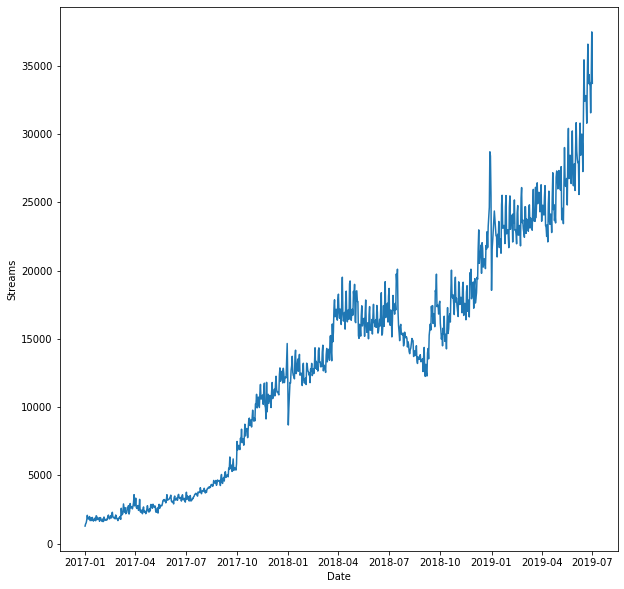

In [14]:
# 今までのトレンド

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.subplots( figsize=(10, 10))
sns.lineplot(x="Date",y="Streams",data=wataridori_trend )

In [7]:
SoY_trend[SoY_trend.Date < "2019-01-01"]

,Date,Track URL,Position,Track Name,Artist,Streams,Country
7088711,2017-01-06,https://open.spotify.com/track/7qiZfU4dY1lWllz...,18,Shape of You,Ed Sheeran,4639,Japan
1355924,2017-01-07,https://open.spotify.com/track/7qiZfU4dY1lWllz...,2,Shape of You,Ed Sheeran,7313,Japan
4171080,2017-01-08,https://open.spotify.com/track/7qiZfU4dY1lWllz...,1,Shape of You,Ed Sheeran,8851,Japan
5255748,2017-01-09,https://open.spotify.com/track/7qiZfU4dY1lWllz...,1,Shape of You,Ed Sheeran,9827,Japan
7848617,2017-01-10,https://open.spotify.com/track/7qiZfU4dY1lWllz...,1,Shape of You,Ed Sheeran,10352,Japan
...,...,...,...,...,...,...,...
1029543,2018-12-27,https://open.spotify.com/track/7qiZfU4dY1lWllz...,9,Shape of You,Ed Sheeran,25225,Japan
635379,2018-12-28,https://open.spotify.com/track/7qiZfU4dY1lWllz...,7,Shape of You,Ed Sheeran,26494,Japan
6441010,2018-12-29,https://open.spotify.com/track/7qiZfU4dY1lWllz...,6,Shape of You,Ed Sheeran,31486,Japan
570691,2018-12-30,https://open.spotify.com/track/7qiZfU4dY1lWllz...,6,Shape of You,Ed Sheeran,32270,Japan


In [42]:
#2019年を予測検証データに用いるため分ける
train= wataridori_trend[ 
    #(wataridori_trend.Date >= "2018-01-01")&
    
    (wataridori_trend.Date < "2018-12-27")].set_index("Date")[["Streams"]]

test = wataridori_trend[wataridori_trend.Date >= "2018-12-27"].set_index("Date")[["Streams"]]

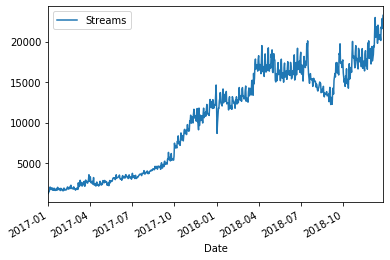

In [10]:
train.plot()

In [44]:
arima_model.predict(start=2,end=len(total_kunren))

2018-01-03     9707.037578
2018-01-04    10080.750007
2018-01-05    11003.550083
2018-01-06    11559.487267
2018-01-07    12145.977249
                  ...     
2019-06-28    19947.365663
2019-06-29    20653.633157
2019-06-30    21006.641707
2019-07-01    20125.086564
2019-07-02    20147.058843
Freq: D, Length: 546, dtype: float64

In [9]:
plt.plot(total_kunren,c="blue", alpha=0.5)
plt.plot(arima_model.predict(start=2,end=z),c="red")

NameError: name 'total_kunren' is not defined

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


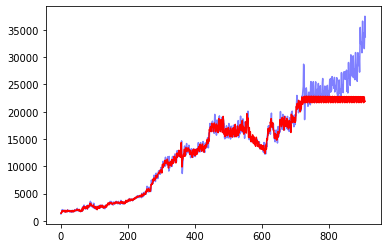

In [74]:
plt.plot(total_kunren.reset_index(drop=True),c="blue", alpha=0.5)
plt.plot(arima_model.predict(start=2,end=len(total_kunren)).reset_index(drop=True),c="red")

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


CPU times: user 5min 48s, sys: 6.09 s, total: 5min 55s
Wall time: 22.6 s


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


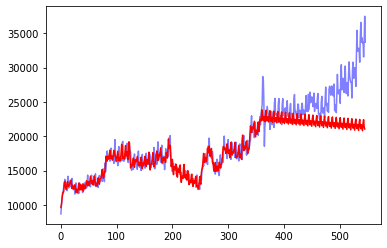

In [21]:
%%time
from statsmodels.tsa.arima_model import ARIMA
total_kunren=pd.concat([train.Streams, test.Streams])
arima_model = ARIMA(train.Streams, order=(5,0,7
                                         )).fit(dist=False,enforce_stationarity=False,)
# plt.plot(arima_model.resid)
plt.plot(total_kunren.reset_index(drop=True),c="blue", alpha=0.5)
plt.plot(arima_model.predict(start=2,end=len(total_kunren)).reset_index(drop=True),c="red")


In [10]:
train_diff1.head()

0       NaN
1    2674.0
2    1538.0
3     976.0
4     525.0
Name: Streams, dtype: float64

In [15]:
params = sm.tsa.arma_order_select_ic(train_diff1.dropna(), ic='aic', trend='c')
params

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


{'aic':              0            1            2
 0  6041.288677  5981.098141  5968.471831
 1  6016.448307  5973.171630  5969.761071
 2  5973.712990  5968.415922  5914.017362
 3  5970.083351  5965.720237  5884.737567
 4  5968.690571  5964.564691  5886.746684, 'aic_min_order': (3, 2)}

階差と、コレログラムをプロット

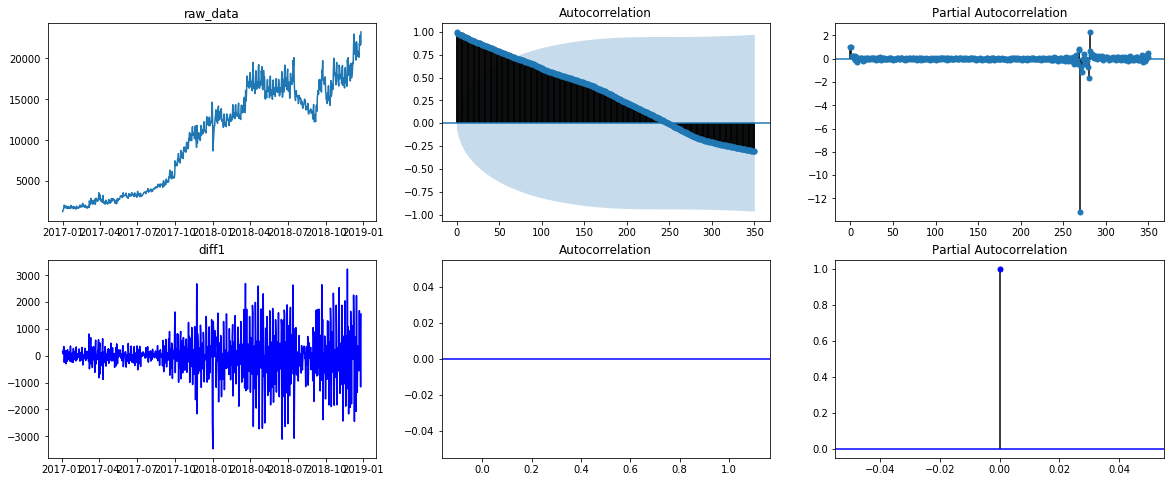

In [43]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import datetime
%matplotlib inline
plt.rcParams["font.size"] = 10
fig, ax = plt.subplots(2, 3, figsize=(20, 8))
axes = ax.flatten()
diff_color = "blue"
# 階差を取得
raw_data = train.Streams
train_diff1 = raw_data.diff()
axes[0].plot(raw_data)
axes[0].set_title("raw_data")
fig = sm.graphics.tsa.plot_acf(raw_data, lags=350, ax=axes[1])
fig = sm.graphics.tsa.plot_pacf(raw_data, lags=350, ax=axes[2])

axes[3].plot(train_diff1.dropna(), color=diff_color, alpha=1)
axes[3].set_title("diff1")
fig = sm.graphics.tsa.plot_acf(train_diff1, lags=40, ax=axes[4], color=diff_color)
fig = sm.graphics.tsa.plot_pacf(train_diff1, lags=40, ax=axes[5], color=diff_color)
# 左から、時系列グラフ、自己相関係数。偏自己相関係数（コレログラム）をプロットしたもの
# 下図は、階差をした上でのグラフとなっている。

In [14]:
res = sm.tsa.arma_order_select_ic(seasonal.resid[~seasonal.resid.isna()], max_ar=5, max_ma=7, ic='aic')
print(res.aic_min_order)

NameError: name 'seasonal' is not defined

In [17]:
seasonal.resid[~seasonal.resid.isna()]

NameError: name 'seasonal' is not defined

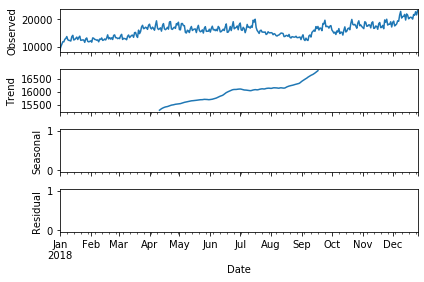

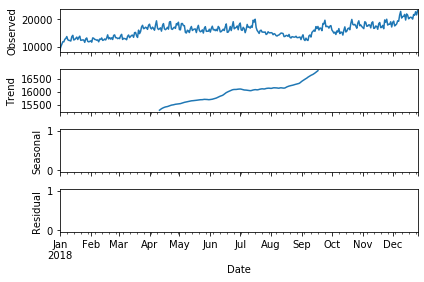

In [18]:
seasonal = sm.tsa.seasonal_decompose(raw_data, freq=200)
seasonal.plot()

In [22]:
# ADF検定(上の時系列が単位根過程であるかを検定する)
sm.tsa.stattools.adfuller(raw_data, 
                                   maxlag=None, 
                                   regression='c', 
                                   autolag='AIC', 
                                   store=False, 
                                   regresults=False)


(-0.7501568569030147,
 0.8333266796710319,
 15,
 344,
 {'1%': -3.4495033946549123,
  '5%': -2.8699787979596136,
  '10%': -2.5712658305164955},
 5530.4816709177485)

In [ ]:

total_data=pd.concat([train.Streams, test.Streams]).reset_index(drop=True)

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('float64') to dtype('int64') with casting rule 'same_kind'

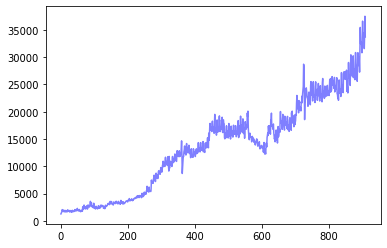

In [83]:
from statsmodels.tsa import arima_model
import matplotlib.pyplot as plt

results=arima_model.ARIMA(train.Streams,order = [0,0,0]).fit()
plt.clf()
plt.plot(pd.concat([train.Streams, test.Streams]).reset_index(drop=True),c="blue", alpha=0.5)
plt.plot(results.predict(start=1,end=730),c="red")
plt.legend(["data","predict"])


In [272]:
train.tail()

,Date,Streams,diff1
838,2019-04-28,30299,186.0
839,2019-04-29,29256,-1043.0
840,2019-04-30,27721,-1535.0
841,2019-05-01,27827,106.0
842,2019-05-02,29113,1286.0


In [ ]:
import itertools
p = [5]
d = [0,1]
q = [10]
sp = [1,2]
sd = [0,2]
sq = [0,1,2]
pdq = list(itertools.product(p, d, q))
# P, D, Q　の組み合わせを列挙するリストを作成すると同時に、後ろに　s = 7　を決め打ちでつけている。
seasonal_pdq = [[x[0], x[1], x[2],
                x[3],x[4],x[5],
    360] for x in list(itertools.product(p,d,q,
                                                                      sp, sd, sq))]
print(pdq, f"配列長は：{len(pdq)}")
print(seasonal_pdq,f"配列長は{len(seasonal_pdq)}")

In [22]:
best_result

[0, 0, 10000000]

In [ ]:
 
best_result = [0, 0, 10000000]
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train.Streams,
                          order = param,
                          seasonal_order=param_seasonal,
                          enforce_stationarity=False,
                          enforce_invertibility=False)
 
            results = mod.fit()
             
            print('order{}, s_order{} - AIC: {}'.format(param, param_seasonal, results.aic))
 
            if results.aic > best_result[2]:
                best_result = [param, param_seasonal, results.aic]
        except:
            continue

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


order(5, 0, 5), s_order[0, 0, 0, 365] - AIC: 12292.966014202508


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


order(5, 0, 5), s_order[0, 1, 0, 365] - AIC: 6284.460742766235


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:981: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


order(5, 0, 5), s_order[1, 0, 0, 365] - AIC: 12300.36036234298


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


order(5, 1, 5), s_order[0, 0, 0, 365] - AIC: 12132.447704740618


NameError: name 'diff1' is not defined

In [ ]:
def aic_calculater(train_data,param):
    try:
        result = sm.tsa.statespace.SARIMAX(train_data,
                                        order=(param[0], param[1], param[2]),
                                   seasonal_order=(param[3], param[4], param[5], param[6]),
                                        enforce_invertibility = False, enforce_stationarity = False,
                                          trend="ct").fit()
#         aic = reuslt.aic
    
        return result
    except:
        return 0

NameError: name 'ps_dump' is not defined

In [ ]:
%%time

import joblib
res_list = joblib.Parallel(n_jobs=-1, verbose=10)([joblib.delayed(aic_calculater)(train.Streams,param) for param in seasonal_pdq])
 
# # AICが小さくなる順にのパラメータの組み合わせを並べ変え


In [20]:
with open("./files/sarima_results.pkl", "wb") as f:
    pickle.dump(res_list,f)

NameError: name 'res_list' is not defined

In [15]:
res_list = [{"gege":"saaa"},0]

In [23]:
[r if r == 0 else r["gege"] for r in res_list  ]

['saaa', 0]

In [ ]:
aic_df = pd.DataFrame({"params": seasonal_pdq, "aic": [r.aic if r == 0 else 0 for r in res_list]})
aic_df.sort_values("aic", inplace=True)
aic_df

In [ ]:
aic_df.head(10)

In [37]:
# import pandas as pd
# use_columns = ["p", "d", "q", "AIC"]
info_df = pd.DataFrame(columns=use_columns)

In [45]:
import itertools
# p = [4,5]
# d = [0,1,2]
# q = [3,4,5]
sp = range(3)
sd = range(2)
sq = range(3)
# pdq = list(itertools.product(p, d, q))
# trial_num = len(p_list) * len(d_list) * len(q_list) *len(sp_list) * len(sd_list) * len(sq_list)

use_columns = ["p", "d", "q", "AIC"]
step_cnt = 0
train_data = raw_data

info_df = pd.DataFrame(columns=use_columns)
for i,param in enumerate(pdq):
    model = sm.tsa.statespace.SARIMAX(train.Streams, order=param, enforce_invertibility=False,
#                                               trend='t'
                                      
                                     )
    p,d,q = param

    try:
        
        res = model.fit(disp=False)
        info_df = info_df.append(pd.Series([p,d,q,res.aic], index=use_columns),ignore_index=True)
    except:
        pass
    print(f"iter {i} finished... param :{param}, aic{res.aic}")
# for p in range(p_num):
#     for d in range(d_num):
#         for q in range(q_num):
#             if p == 0 and q == 0:
#                 continue
#             model = sm.tsa.statespace.SARIMAX(train.Streams, order=param, enforce_invertibility=True,
#                                               trend='t')
#             param_list = [p, d, q]
#             for name, val in zip(use_columns[:-1], param_list):
#                 info_df.iloc[step_cnt][name] = val
#             try:
#                 result = model.fit(disp=False)
#                 # print(result.aic)
#                 info_df.iloc[step_cnt]["AIC"] = result.aic
#             except:
#                 pass
#             step_cnt += 1
#             print("Finish trial No. {}, Param: {}".format(step_cnt, param_list))

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


iter 0 finished... param :(4, 0, 3), aic14470.473082995488


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


iter 1 finished... param :(4, 0, 4), aic14422.988875771864


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


iter 2 finished... param :(4, 0, 5), aic14378.301322314604


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


iter 3 finished... param :(4, 1, 3), aic14326.940804186019


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


iter 4 finished... param :(4, 1, 4), aic14336.548555424903


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


iter 5 finished... param :(4, 1, 5), aic14261.905609171314
iter 6 finished... param :(4, 2, 3), aic14436.371483751755


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


iter 7 finished... param :(4, 2, 4), aic14409.605093594371


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


iter 8 finished... param :(4, 2, 5), aic14379.079233190983


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


iter 9 finished... param :(5, 0, 3), aic14434.226485915256


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


iter 10 finished... param :(5, 0, 4), aic14354.932488315348


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


iter 11 finished... param :(5, 0, 5), aic14352.487057624134


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


iter 12 finished... param :(5, 1, 3), aic14276.780453344385


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


iter 13 finished... param :(5, 1, 4), aic14227.51366391924


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


iter 14 finished... param :(5, 1, 5), aic14231.896564833105


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


iter 15 finished... param :(5, 2, 3), aic14400.208135195775


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


iter 16 finished... param :(5, 2, 4), aic14342.73756882191
iter 17 finished... param :(5, 2, 5), aic14356.469587458154


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [46]:
info_df.sort_values(by="AIC")

,p,d,q,AIC
13,5.0,1.0,4.0,14227.513664
14,5.0,1.0,5.0,14231.896565
5,4.0,1.0,5.0,14261.905609
12,5.0,1.0,3.0,14276.780453
3,4.0,1.0,3.0,14326.940804
4,4.0,1.0,4.0,14336.548555
16,5.0,2.0,4.0,14342.737569
11,5.0,0.0,5.0,14352.487058
10,5.0,0.0,4.0,14354.932488
17,5.0,2.0,5.0,14356.469587


In [105]:
def make_lbtest_df(test_data, lags=10):
    test_result = sm.stats.diagnostic.acorr_ljungbox(test_data, lags=lags)
    lbtest_df = pd.DataFrame({
        "Q": test_result[0],"p-value": test_result[1]})
    lbtest_df = lbtest_df[["Q", "p-value"]]
    return lbtest_df

25分くらいかかる

In [ ]:
%%time
model= sm.tsa.statespace.SARIMAX(train.Streams, order=(5,1,10),
                                 seasonal_order= (1, 0, 0, 250),#(1,0,0)
                                 trend="ct",
                                 enforce_stationarity = False,
                                 enforce_invertibility=False)
results = model.fit()
print(results.summary())

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [39]:
model514= sm.tsa.statespace.ARIMA(train.Streams, order=(5, 1, 5), trend='c')
# order(5, 0, 5), s_order[0, 1, 0, 365]
results514 = model514.fit()
print(results514.summary())

AttributeError: module 'statsmodels.tsa.statespace.api' has no attribute 'ARIMA'

In [ ]:
resid = results.resid
print(resid.mean())
lbtest514 = make_lbtest_df(resid)
# lbtest202.index = range(1, 11)
lbtest514

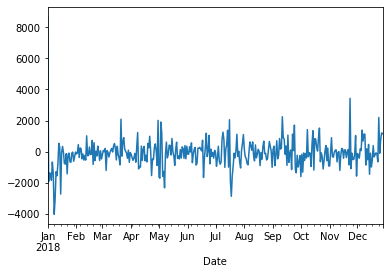

In [142]:
results.resid.plot()

In [109]:
results.mle_retvals

{'fopt': 5.901378495647604,
 'gopt': array([-2.53832511e-06, -2.96424991e-03,  5.66136960e-03,  5.01785262e-03,
        -1.09193437e-03, -6.25129637e-04,  7.41304262e-04,  8.02440958e-04,
        -1.85590521e-03, -1.22629524e-03,  1.59606088e-03,  3.93594490e-05]),
 'fcalls': 793,
 'warnflag': 1,
 'converged': False,
 'iterations': 50}

In [101]:
plt.clf()
pd.concat([train.Streams, test.Streams]).reset_index(drop=True)
plt.plot(pd.concat([train.Streams, test.Streams]).reset_index(drop=True),c="blue", alpha=0.5)
plt.plot(results.predict(start=1,end=1200),c="red")
plt.legend(["data","predict"])


ValueError: view limit minimum -36894.75 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

In [23]:
print(len(pd.concat([train.Streams, test.Streams]).reset_index(drop=True)))

904


In [67]:
len(train.Streams)

722

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


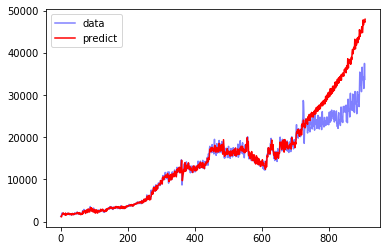

In [31]:
# train.Streams, order=(5,1,10),
#                                  seasonal_order= (1, 1, 0, 300)
# trend = "ct"
total_kunren=pd.concat([train.Streams, test.Streams])
plt.plot(total_kunren.reset_index(drop=True),c="blue", alpha=0.5)
plt.plot(results.predict(start=1,end=len(total_kunren)),c="red")
plt.legend(["data","predict"])

In [ ]:
total_kunren=pd.concat([train.Streams, test.Streams])
plt.plot(total_kunren.reset_index(drop=True),c="blue", alpha=0.5)
plt.plot(results.predict(start=1,end=730).reset_index(drop=True),c="red")
plt.legend(["data","predict"])


In [66]:
results.predict(start=1,end=len(total_kunren)).min()

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


837.7590202579155

In [108]:
results.aic

4296.598030848865

In [72]:
results.predict(start=1,end=len(total_kunren))

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


1       1527.225218
2        837.759020
3       1171.933239
4       1486.985057
5       1539.330749
           ...     
905    22582.838192
906    23275.731019
907    23638.616799
908    23107.251837
909    22734.424745
Length: 909, dtype: float64